# Utility Section

Imports

In [1]:
# Import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from typing import Iterable

Utils class

In [2]:
# Utility class for HW_2 
class Utils(): 

    __X = None
    __Y = None

    def normal_equation(dataset:pd.DataFrame, use_regularization:bool=False) -> np.ndarray:
        x, y, _ = Utils.get_x_y_h_vals(dataset, use_regularization)
        x_t = np.transpose(x)
        x_t_dot_x = np.dot(x_t, x)
        x_t_dot_y = np.dot(x_t, y)
        weights = np.dot(np.linalg.inv(x_t_dot_x), x_t_dot_y)
        return weights

    def GD_EX1(weights:np.ndarray, 
               dataset:pd.DataFrame, 
               alpha:float=0.1,
               epsilon: float=1e-7,
               max_iters:int=1e6, 
               use_regularization:bool=False,
               plot_cost_iterations:bool=False) -> np.ndarray:
        """
        Method to calculate new weights for a linear regression model with 
        Gradient-Descent [GD] algorithm.
        The method will run until convergence or one of the two options below:
            1. ascending step measure
            2. reach max_iter limit

        Args:
            weights [type: np.array]: initial weights value.
            dataset [type: pd.DataFrame]: data set for linear regression.
            alpha [type: float]: GD learning rate.
                                 default value --> 0.1.
            epsilon [type: float]: limit of change between new and last cost values
                                   to be considered as convergence.
                                   default value --> 1e-7.
            plot_cost_iterations [type: bool]: decide if cost over iterations 
                                               scatter plot will be printed during
                                               iterations.
                                               default value --> False.
            use_regularization [type: bool]: decide if x values will be regularized.
                                             default value --> False.

        Raises:
            1. Exception: Failed to converge with max iters.
            2. Exception: Cost function ascending detected!

        Returns:
            weights [type: np.array]: new value of weights calculated during iterations.
        """

        err_msg = f'Failed to converge with max iters: {max_iters}'
        cost_values = []
        last_cost = Utils.calc_cost(weights, dataset, use_regularization)
        cost_values.append(last_cost)
        new_cost = 0.0
        iter = 0

        while not Utils.__check_convergence(last_cost, new_cost, epsilon):
            if iter == max_iters: raise Exception(err_msg)
            weights = Utils.calc_GD_new_weights(weights, dataset, alpha, use_regularization)
            last_cost = new_cost if iter > 0 else last_cost
            new_cost = Utils.calc_cost(weights, dataset, use_regularization)
            cost_values.append(new_cost)
            iter+=1

        if plot_cost_iterations:
            plt.plot(range(0, iter+1), cost_values)
            plt.xlabel('Iterations', size=12)
            plt.ylabel('J(Θ)', size=12)
            plt.title(f'J(Θ) over number of iterations graph for alpha={alpha}', 
                      size=18, fontweight="bold")
        return weights
    
    def calc_cost(weights:np.ndarray, dataset:pd.DataFrame, use_regularization:bool) -> float:
        _, y, h = Utils.get_x_y_h_vals(dataset, use_regularization, weights)
        m = y.shape[0]
        cost = (np.sum((h-y)**2))/(2*m)
        return float(cost)
    
    def calc_GD_new_weights(weights:np.ndarray, 
                            dataset:pd.DataFrame, 
                            alpha:float,
                            use_regularization:bool) -> np.ndarray:
        x, y, h = Utils.get_x_y_h_vals(dataset, use_regularization, weights)
        m = y.shape[0]
        grads = (alpha/m)*np.dot(np.transpose(x),(h-y))
        grads = grads.reshape(weights.shape[0], 1)
        weights = weights - grads 
        return weights

    def get_x_y_h_vals(dataset:pd.DataFrame, use_regularization:bool, weights:np.ndarray=None) -> np.ndarray:
        x = Utils.__get_x_vals(dataset, use_regularization)
        y = Utils.__get_y_vals(dataset, x, use_regularization)
        h = x.dot(weights) if weights is not None else None
        return x, y, h

    def reset_variables() -> None:
        Utils.__X = None
        Utils.__Y = None

    def __check_convergence(last_cost:float, new_cost:float, epsilon:float) -> bool:
        ascending = new_cost > last_cost
        ascending_err_msg = f'Cost function ascending detected!\n' +\
                            f'New cost: {new_cost}, Last cost: {last_cost}'
        if ascending: raise Exception(ascending_err_msg)
        step_change = np.abs(last_cost-new_cost)
        is_converge = step_change < epsilon
        return is_converge
    
    def __get_x_vals(dataset:pd.DataFrame, use_regularization:bool) -> np.ndarray:
        if Utils.__X is None:
            x = dataset.iloc[:,:-1]
            if use_regularization:
                x_min = np.min(x)
                x_max = np.max(x)
                x_mean = np.mean(x)
                x = (x-x_mean)/(x_max-x_min)
            ones = np.ones((x.shape[0], 1)) 
            x = np.concatenate((ones, x), axis=1)
            Utils.__X = x
        return Utils.__X
    
    def __get_y_vals(dataset:pd.DataFrame, x:np.ndarray, use_regularization:bool) -> np.ndarray:
        if Utils.__Y is None:
            y = np.array(dataset.iloc[:,-1])
            y = y.reshape(x.shape[0], 1)
            if use_regularization:
                y_min = np.min(y)
                y_max = np.max(y)
                y_mean = np.mean(y)
                y = (y-y_mean)/(y_max-y_min)
            Utils.__Y = y
        return Utils.__Y
   
    def get_init_weights(dataset:pd.DataFrame) -> np.array:
        num_of_featues = (dataset.shape[1])
        weights = np.random.rand(num_of_featues, 1)
        weights[0] = 1
        weights = np.array(weights)
        return weights
    
class LinearRegressionModel():

    def __init__(self, 
                 alpha_list:Iterable[float], 
                 dataset:pd.DataFrame,
                 init_weights: np.ndarray,
                 use_regularization:bool,
                 max_iters:int=1000000,
                 epsilon:float=1e-7):
        self.alpha_list=alpha_list
        self.dataset=dataset
        self.init_weights=init_weights
        self.use_regularization=use_regularization
        self.max_iters=max_iters
        self.epsilon=epsilon
        self.__gd__weights = None
        self.__ne_weights = None
    
    def train_model(self) -> None:
        Utils.reset_variables()
        self.__ne_weights = Utils.normal_equation(self.dataset, self.use_regularization)
        gd_error_mean_best = None
        fig_num = 1

        for alpha in self.alpha_list:
            try:
                plt.figure(fig_num)
                gd_weights = Utils.GD_EX1(weights=self.init_weights, 
                                          dataset=self.dataset, 
                                          alpha=alpha,
                                          use_regularization=self.use_regularization,
                                          plot_cost_iterations=True,
                                          max_iters=self.max_iters,
                                          epsilon=self.epsilon)
                plt.show()
                fig_num+=1
                
                weights_zipped = list(zip(gd_weights, self.__ne_weights))
                error = list(map(lambda w: np.round((abs((w[0]-w[1])/w[1]))*100, 2), weights_zipped))
                error_mean = np.mean(error)
                if gd_error_mean_best is None or error_mean < gd_error_mean_best:
                    gd_error_mean_best = error_mean
                    self.__gd__weights = gd_weights

                print(f'GD weights: {gd_weights}\n')
                print(f'NE weights: {self.__ne_weights}\n')

                print(f'Errors for learning rate [alpha]: {alpha}')
                for i in range(0,len(error)):
                    msg = f'Θ{i} error: {error[i][0]}%'
                    print(msg)
            except Exception as e:
                err_msg = f'Caught exception for learning rate of: {alpha}.\n' +\
                          f'Message: {e}\n'
                print(err_msg)
        
        print(f'\nBest gd weights: {self.__gd__weights}')
        print(f'\nBest gd errors mean: {gd_error_mean_best}%')

    def get_gd_weights(self) -> np.ndarray: 
        return self.__gd__weights

    def get_ne_weights(self) -> np.ndarray: 
        return self.__ne_weights  


# Single Variable Linear Regression

CSV file loads

In [ ]:
base_path = os.path.abspath(os.curdir)

q1_data_path = f"{base_path}\\ex1data1.txt"
q1_df = pd.read_csv(q1_data_path, sep=',', header=None)

q2_data_path = f"{base_path}\\ex1data2.txt"
q2_df = pd.read_csv(q2_data_path, sep=',', header=None) #  names = ['Size [square feet]', 'Number of rooms', 'Price']
print(q2_df)

Scatter plot of first data file 

In [ ]:
# Create a scatter plot of income over Population
x = q1_df[0]
y = q1_df[1]
plt.scatter(x, y)

# Labels
plt.xlabel('Incomes [K₪]', size=12)
plt.ylabel('Population [10^4 people]', size=12)
plt.title('Food truck income over population', size=18, fontweight='bold')

GD_EX1 test - J(Θ) over number of iterations graphs for different learning rates

Caught exception for learning rate of: 100.
Message: Cost function ascending detected!
New cost: 4900.538766517811, Last cost: 0.5082303689494463

Caught exception for learning rate of: 10.
Message: Cost function ascending detected!
New cost: 40.50671807844779, Last cost: 0.5082303689494463



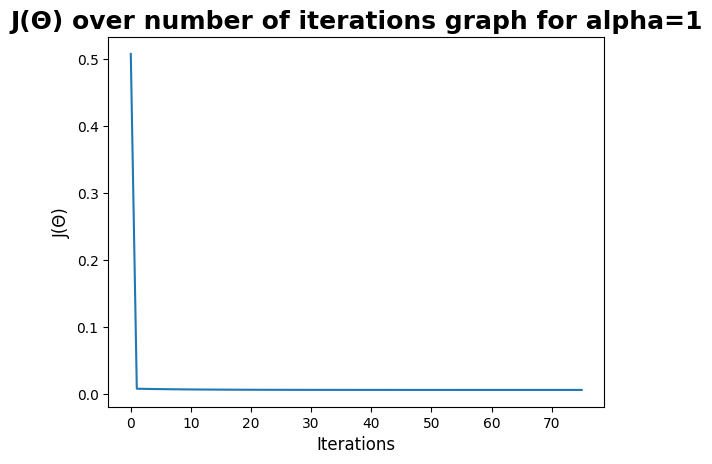

GD weights: [[-8.52697065e-17]
 [ 7.57900525e-01]]

NE weights: [[-8.77935407e-17]
 [ 7.63824897e-01]]

Errors for learning rate [alpha]: 1
Θ0 error: 2.87%
Θ1 error: 0.78%


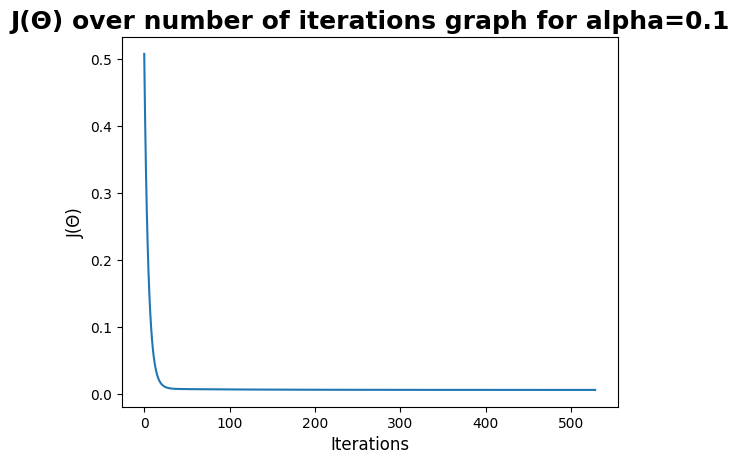

GD weights: [[-7.79171942e-17]
 [ 7.44025465e-01]]

NE weights: [[-8.77935407e-17]
 [ 7.63824897e-01]]

Errors for learning rate [alpha]: 0.1
Θ0 error: 11.25%
Θ1 error: 2.59%


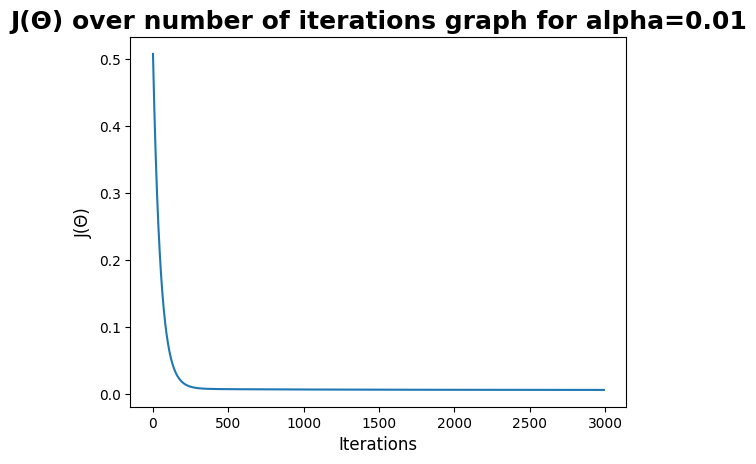

GD weights: [[8.71164017e-14]
 [7.00931365e-01]]

NE weights: [[-8.77935407e-17]
 [ 7.63824897e-01]]

Errors for learning rate [alpha]: 0.01
Θ0 error: 99328.71%
Θ1 error: 8.23%


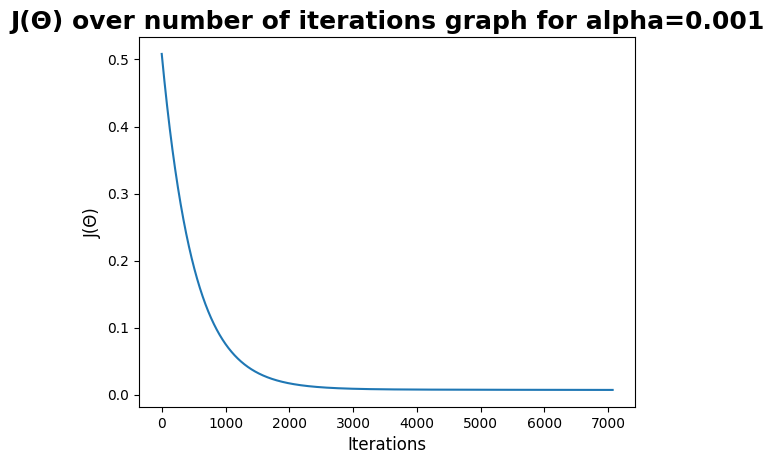

GD weights: [[0.00084808]
 [0.56551376]]

NE weights: [[-8.77935407e-17]
 [ 7.63824897e-01]]

Errors for learning rate [alpha]: 0.001
Θ0 error: 965992389562759.6%
Θ1 error: 25.96%


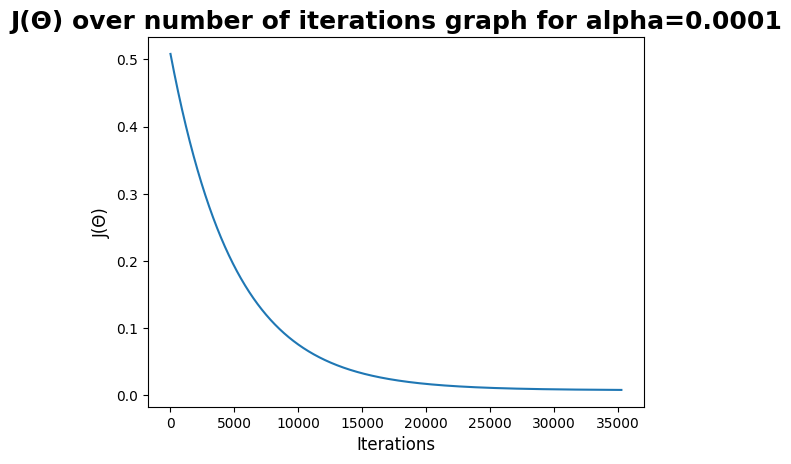

GD weights: [[0.02929388]
 [0.52692597]]

NE weights: [[-8.77935407e-17]
 [ 7.63824897e-01]]

Errors for learning rate [alpha]: 0.0001
Θ0 error: 3.3366787306757892e+16%
Θ1 error: 31.01%


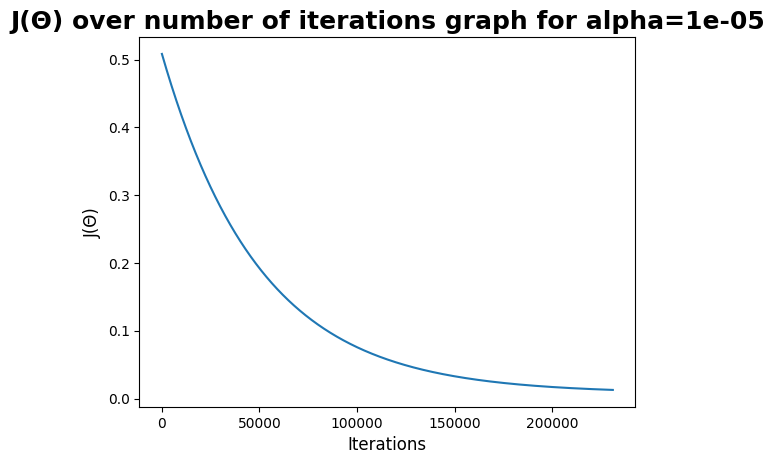

GD weights: [[0.09919461]
 [0.51195739]]

NE weights: [[-8.77935407e-17]
 [ 7.63824897e-01]]

Errors for learning rate [alpha]: 1e-05
Θ0 error: 1.1298623324778174e+17%
Θ1 error: 32.97%

Best gd weights: [[-8.52697065e-17]
 [ 7.57900525e-01]]

Best gd errors mean: 1.8250000000000002%


In [11]:
single_variable_model = LinearRegressionModel(
    alpha_list=[100, 10, 1, 0.1, 0.01, 0.001, 1e-4, 1e-5],
    dataset=q1_df,
    init_weights=Utils.get_init_weights(q1_df), # np.array([[1],[2]])
    use_regularization=True
)

single_variable_model.train_model()

Plot of data set's scatter with the NE and GD lines

In [ ]:
x = q1_df[0]
y = q1_df[1]
plt.scatter(x, y)

theta0 = single_variable_model.get_ne_weights()[0]
theta1 = single_variable_model.get_ne_weights()[1]
f = lambda x: theta0 + theta1*x
x_line = np.linspace(np.min(x), np.max(x), 10000)
plt.plot(x_line, f(x_line), color='red', label='NE')

theta0 = single_variable_model.get_gd_weights()[0]
theta1 = single_variable_model.get_gd_weights()[1]
plt.plot(x_line, f(x_line), color='green', label='GD')

# add labels to the plot
plt.xlabel("Incomes [K₪]", size=12)
plt.ylabel("Population [10^4 people]", size=12)
plt.title("NE linear model VS GD linear model", size=18,  fontweight='bold')
plt.legend()

Plots of cost functions (contur and 3D graphs)

In [ ]:
theta0 = np.linspace(-10, 10, 1000)
theta1 = np.linspace(-10, 10, 1000)

cost = []
for i in range(0, len(theta0)):
    for j in range(0, len(theta1)):
        weights = [[theta0[i]], [theta1[j]]]
        cost.append(Utils.calc_cost(weights, q1_df, use_regularization=True))

t0_msh, t1_msh = np.meshgrid(theta0 ,theta1)
cost = np.array(cost).reshape(t0_msh.shape)

plt.contour(t0_msh, t1_msh, np.array(cost), cmap='RdGy')
plt.xlabel("Θ0", size=12)
plt.ylabel("Θ1", size=12)
plt.title("J(Θ) contour map", size=18,  fontweight='bold')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(t0_msh, t1_msh, cost, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel("Θ0", size=12)
plt.ylabel("Θ1", size=12)
plt.title("J(Θ) 3D surface", size=18,  fontweight='bold')

# Multi Variables Linear Regression

Visualize the data set

Text(0.5, 0.92, 'House Price Over Size & Num Badrooms')

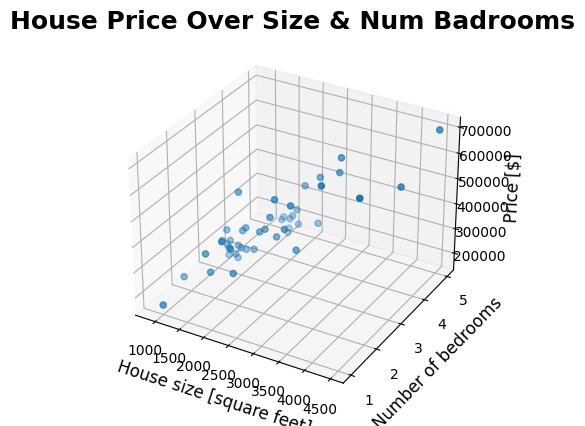

In [30]:
x1 = q2_df[0]
x2 = q2_df[1]
y = q2_df[2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, y)
ax.set_xlabel('House size [square feet]', size=12)
ax.set_ylabel('Number of bedrooms', size=12)
ax.set_zlabel('Price [$]', size=12)
plt.title('House Price Over Size & Num Badrooms', size=18,  fontweight='bold')

Train model with regularization

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=ax

Caught exception for learning rate of: 100.
Message: Cost function ascending detected!
New cost: 4900.528566822953, Last cost: 0.5126047260548643

Caught exception for learning rate of: 10.
Message: Cost function ascending detected!
New cost: 40.51054735892044, Last cost: 0.5126047260548643



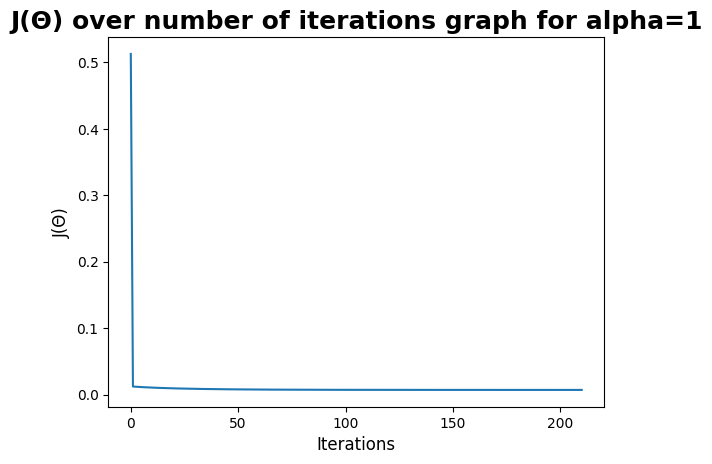

GD weights: [[-2.87890279e-17]
 [ 9.41728995e-01]
 [-5.22185002e-02]]

NE weights: [[-2.37250482e-17]
 [ 9.52411140e-01]
 [-6.59473141e-02]]

Errors for learning rate [alpha]: 1
Θ0 error: 21.34%
Θ1 error: 1.12%
Θ2 error: 20.82%


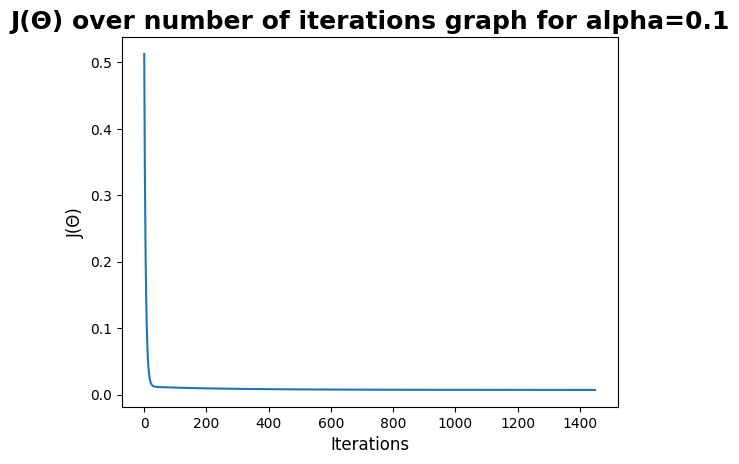

GD weights: [[-2.67400712e-17]
 [ 9.17660127e-01]
 [-2.13025974e-02]]

NE weights: [[-2.37250482e-17]
 [ 9.52411140e-01]
 [-6.59473141e-02]]

Errors for learning rate [alpha]: 0.1
Θ0 error: 12.71%
Θ1 error: 3.65%
Θ2 error: 67.7%


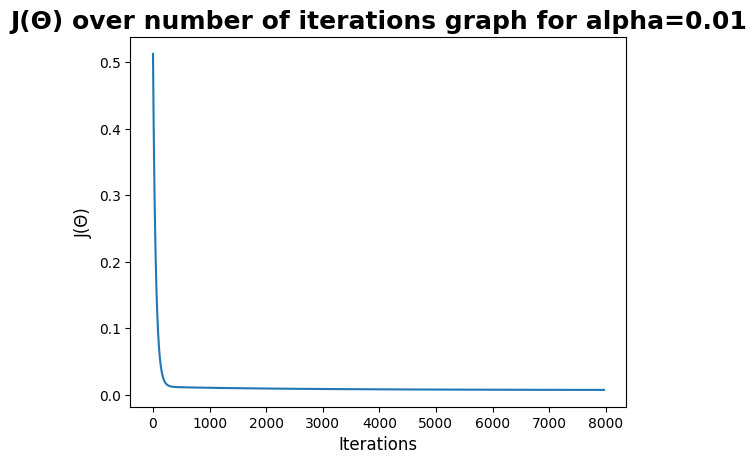

GD weights: [[-2.94088057e-17]
 [ 8.41755535e-01]
 [ 7.49850420e-02]]

NE weights: [[-2.37250482e-17]
 [ 9.52411140e-01]
 [-6.59473141e-02]]

Errors for learning rate [alpha]: 0.01
Θ0 error: 23.96%
Θ1 error: 11.62%
Θ2 error: 213.7%


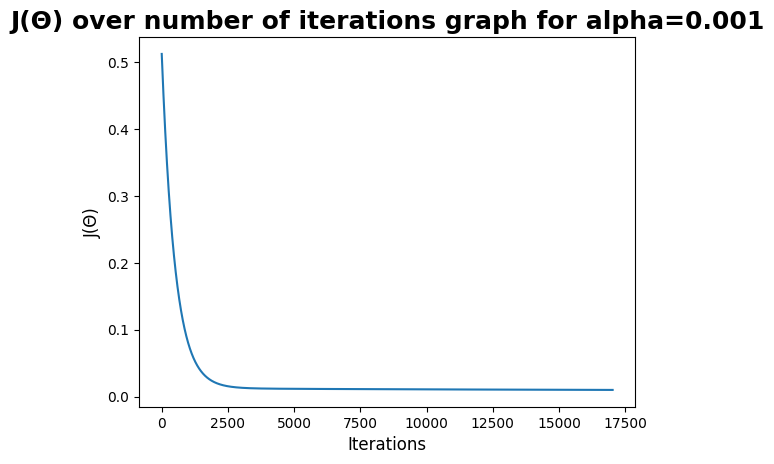

GD weights: [[3.98349694e-08]
 [5.83896093e-01]
 [3.33097767e-01]]

NE weights: [[-2.37250482e-17]
 [ 9.52411140e-01]
 [-6.59473141e-02]]

Errors for learning rate [alpha]: 0.001
Θ0 error: 167902585907.64%
Θ1 error: 38.69%
Θ2 error: 605.1%


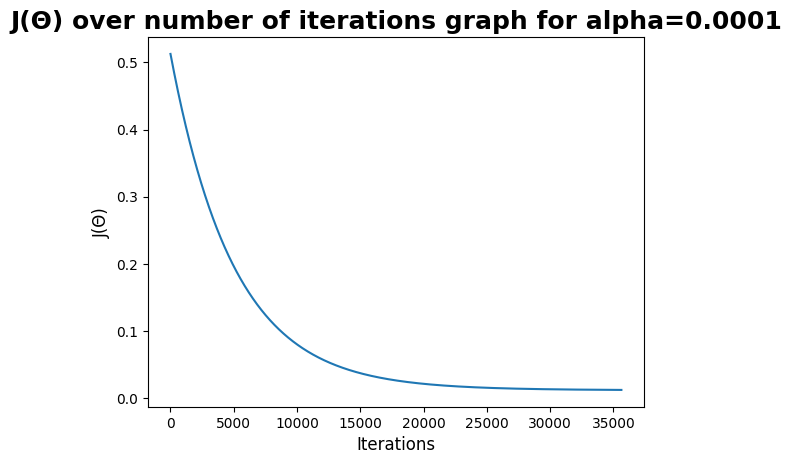

GD weights: [[0.02833158]
 [0.44440451]
 [0.40848357]]

NE weights: [[-2.37250482e-17]
 [ 9.52411140e-01]
 [-6.59473141e-02]]

Errors for learning rate [alpha]: 0.0001
Θ0 error: 1.1941632261695022e+17%
Θ1 error: 53.34%
Θ2 error: 719.41%


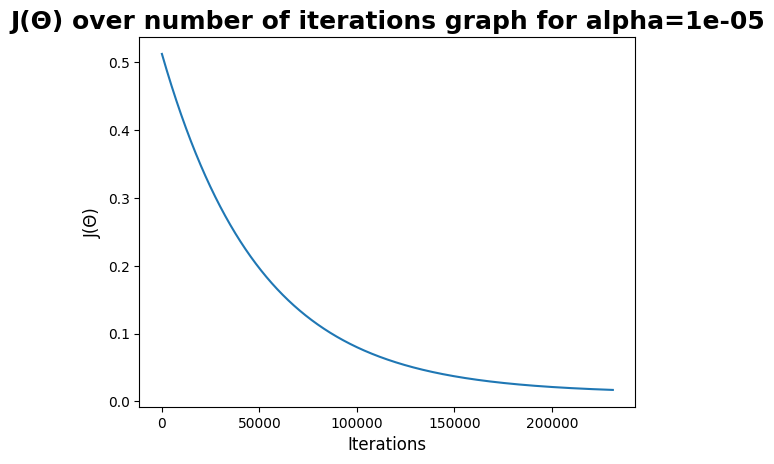

GD weights: [[0.09893012]
 [0.42770441]
 [0.41488732]]

NE weights: [[-2.37250482e-17]
 [ 9.52411140e-01]
 [-6.59473141e-02]]

Errors for learning rate [alpha]: 1e-05
Θ0 error: 4.169859474633021e+17%
Θ1 error: 55.09%
Θ2 error: 729.12%

Best gd weights: [[-2.87890279e-17]
 [ 9.41728995e-01]
 [-5.22185002e-02]]

Best gd errors mean: 14.426666666666668%


In [10]:
multi_var_regularized_model = LinearRegressionModel(
    alpha_list=[100, 10, 1, 0.1, 0.01, 0.001, 1e-4, 1e-5],
    dataset=q2_df,
    init_weights=Utils.get_init_weights(q2_df),
    use_regularization=True
)

multi_var_regularized_model.train_model()

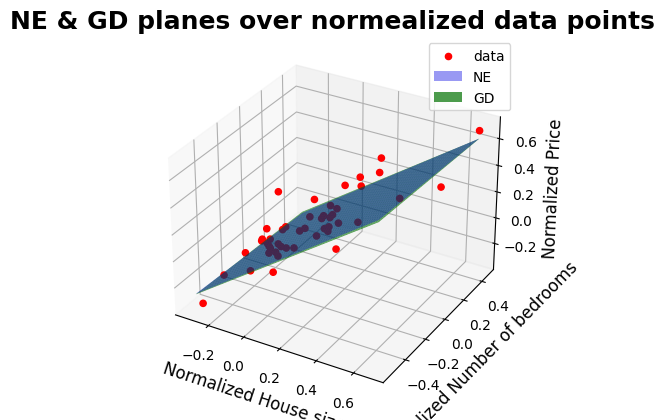

In [12]:
x1 = q2_df[0]
x1 = (x1-np.mean(x1))/(np.max(x1)-np.min(x1))
x2 = q2_df[1]
x2 = (x2-np.mean(x2))/(np.max(x2)-np.min(x2))
y = q2_df[2]
y = (y-np.mean(y))/(np.max(y)-np.min(y))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, y, color='red', alpha=1)
ax.set_xlabel('Normalized House size', size=12)
ax.set_ylabel('Normalized Number of bedrooms', size=12)
ax.set_zlabel('Normalized Price', size=12)
plt.title('NE & GD planes over normealized data points', size=18,  fontweight='bold')

theta0 = multi_var_regularized_model.get_ne_weights()[0]
theta1 = multi_var_regularized_model.get_ne_weights()[1]
theta2 = multi_var_regularized_model.get_ne_weights()[2]
x1 = np.linspace(np.min(x1), np.max(x1), 10000)
x2 = np.linspace(np.min(x2), np.max(x2), 10000)
x1, x2 = np.meshgrid(x1 ,x2)
f = lambda x1, x2: theta0 + theta1*x1 + theta2*x2
s1 = ax.plot_surface(x1, x2, f(x1,x2), color='blue', alpha=0.4)
s1._edgecolors2d = s1._edgecolor3d
s1._facecolors2d = s1._facecolor3d

theta0 = multi_var_regularized_model.get_gd_weights()[0]
theta1 = multi_var_regularized_model.get_gd_weights()[1]
theta2 = multi_var_regularized_model.get_gd_weights()[2]
s2 = ax.plot_surface(x1, x2, f(x1,x2), color='green', alpha=0.7)
s2._edgecolors2d = s2._edgecolor3d
s2._facecolors2d = s2._facecolor3d

plt.legend(['data', 'NE', 'GD'])

Train model without regolarozation

Caught exception for learning rate of: 0.0001.
Message: Cost function ascending detected!
New cost: 1.328154449322788e+16, Last cost: 64870032133.49733

Caught exception for learning rate of: 1e-10.
Message: Failed to converge with max iters: 10000000.0



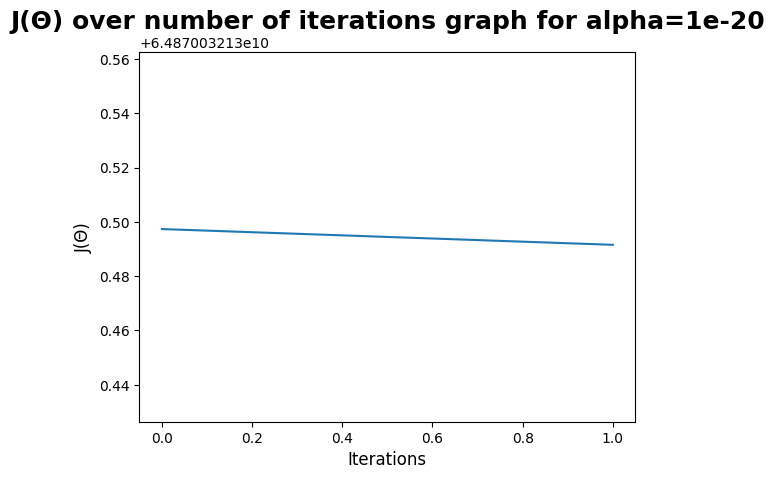

GD weights: [[1.        ]
 [0.94574641]
 [0.44516188]]

NE weights: [[89597.9095428 ]
 [  139.21067402]
 [-8738.01911233]]

Errors for learning rate [alpha]: 1e-20
Θ0 error: 100.0%
Θ1 error: 99.32%
Θ2 error: 100.01%


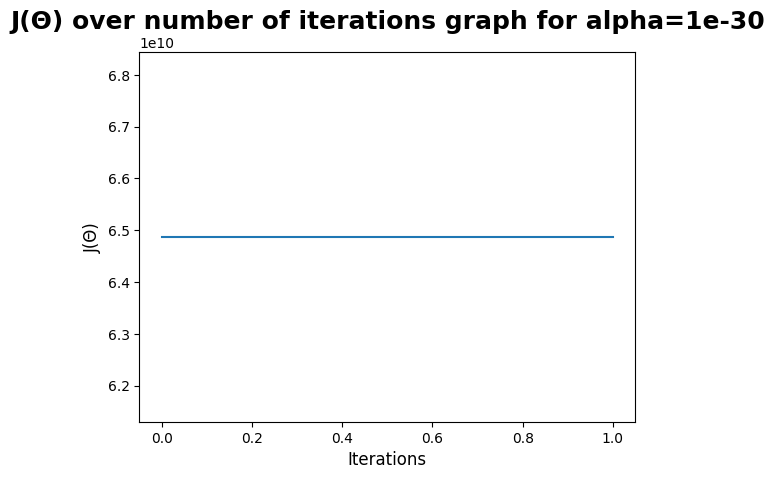

GD weights: [[1.        ]
 [0.94574641]
 [0.44516188]]

NE weights: [[89597.9095428 ]
 [  139.21067402]
 [-8738.01911233]]

Errors for learning rate [alpha]: 1e-30
Θ0 error: 100.0%
Θ1 error: 99.32%
Θ2 error: 100.01%

Best gd weights: [[1.        ]
 [0.94574641]
 [0.44516188]]

Best gd errors mean: 99.77666666666666%


In [34]:
multi_var_non_regularized_model = LinearRegressionModel(
    alpha_list=[0.0001, 1e-10, 1e-20, 1e-30],
    dataset=q2_df,
    init_weights=Utils.get_init_weights(q2_df), # np.array([[3],[2],[1]])
    use_regularization=False,
    epsilon=1e-2,
    max_iters=1e7
)

multi_var_non_regularized_model.train_model()